In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

import matplotlib.colors as colors
import matplotlib.cbook as cbook
import matplotlib.pyplot as plt

import mlflow
import mlflow.tensorflow

import uuid

from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import multilabel_confusion_matrix

from eis.EISDataIO import eis_dataframe_from_csv

from os import path
import logging

2022-03-21 23:50:18.760283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 23:50:18.760326: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# loading training data

# if you are on a windows machine un-comment the following line to get the path to training data
# here = !echo %cd%

# if you are on a mac/ unix machine un-comment the following line to get the path to training data
here = !pwd

train_data_path = path.join(path.dirname(here[0]), "train_data.csv")
eis_data = eis_dataframe_from_csv(train_data_path)

In [3]:
def complex_parts(cmp: pd.Series) -> tuple[pd.Series, pd.Series]:
    real_part= cmp.apply(np.real)
    imag_part= cmp.apply(np.imag)
    return (real_part, imag_part)

eis_data["Z_real"], eis_data["Z_imag"] = complex_parts(eis_data.Z)
# display(eis_data)

In [4]:
def drange(cmp: pd.Series) -> tuple[pd.Series, pd.Series]:
    min_= cmp.apply(np.min)
    max_= cmp.apply(np.max)
    return (min_, max_)

eis_data["freq_min"], eis_data["freq_max"] = drange(eis_data.freq)
eis_data["Z_real_min"], eis_data["Z_real_max"] = drange(eis_data.Z_real)
eis_data["Z_imag_min"], eis_data["Z_imag_max"] = drange(eis_data.Z_imag)
#display(eis_data)

In [5]:
def minmaxer(cmp: pd.Series, min_, max_) -> pd.Series:
    minmaxed = (cmp-min_)/(max_-min_)
    return minmaxed

Z_real_min = eis_data["Z_real_min"].min()
Z_real_max = eis_data["Z_real_max"].max()
Z_imag_min = eis_data["Z_imag_min"].min()
Z_imag_max = eis_data["Z_imag_max"].max()
eis_data["Z_real_minmaxed"] = minmaxer(eis_data.Z_real,Z_real_min,Z_real_max)
eis_data["Z_imag_minmaxed"] = minmaxer(eis_data.Z_imag,Z_imag_min,Z_imag_max)
#display(eis_data)

In [6]:
from typing import List
def input_prepro(cmp: pd.DataFrame, cols: List) -> tuple[pd.Series, pd.Series]:
    res_col = []
    mask_col = []
    n_cols = len(cols)
    for idx, r in cmp.iterrows():
        len_data=len(r[cols[0]])
        res = np.zeros([83,n_cols])
        mask = np.zeros([83,1])
        mask[0:len_data]=1
        
        for i, c in enumerate(cols):
            res[0:len_data,i]=r[c]
            
        res_col.append(res)
        mask_col.append(mask)
    
    return (pd.Series(res_col), pd.Series(mask_col))

In [7]:
eis_data["input_data"],eis_data["input_mask"] = input_prepro(eis_data, ["freq", "Z_real", "Z_imag"])

# display(eis_data)
#display(eis_data["input_data"].to_numpy())

In [8]:
# Utility for our sequence model.

def get_sequence_model(max_seq_len: int,N_features: int,N_classes: int , lr: float = 0.01):
    #Max sequence lenght: 83, Number of features: 3

    eis_features_input = keras.Input((max_seq_len, N_features))
    mask_input = keras.Input((max_seq_len,), dtype="bool")
    x = keras.layers.LSTM(16, return_sequences=True)(
        eis_features_input, mask=mask_input
    )

    x = keras.layers.LSTM(8,return_sequences=True)(x)
    x = keras.layers.LSTM(8,return_sequences=True)(x)
    
    # Add convolutional layers
    x = keras.layers.Conv1D(filters=32,kernel_size=3,activation="relu")(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Conv1D(filters=16,kernel_size=3,activation="relu")(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Conv1D(filters=8,kernel_size=3,activation="relu")(x)
    x = keras.layers.Dropout(0.1)(x)
    
    #Global pooling to return to dense type
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = layers.BatchNormalization()(x)
    
    x = keras.layers.Dense(8, activation="relu")(x)
    x = keras.layers.Dense(8, activation="relu")(x)

    # Number of posible classes at the output
    output = keras.layers.Dense(N_classes, activation="softmax")(x)
    rnn_model = keras.Model([eis_features_input, mask_input], output)

    
    model_optimizer= keras.optimizers.Adam(learning_rate=lr)
    
    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=model_optimizer, metrics=["accuracy"]
    )

    return rnn_model

In [9]:
mymodel = get_sequence_model(83, 3, 9, 0.01)
mymodel.summary()

2022-03-21 23:50:41.623422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-21 23:50:41.623473: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-21 23:50:41.623492: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e22088692a9b): /proc/driver/nvidia/version does not exist
2022-03-21 23:50:41.623863: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 83, 3)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 83)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 83, 16)       1280        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 83, 8)        800         ['lstm[0][0]']               

In [10]:
myohe = LabelBinarizer()
output = myohe.fit_transform(eis_data["Circuit"])

In [11]:
# Create mapping for labels and classes
classes_dict = {}
for i,cl in enumerate(myohe.classes_):
    classes_dict[i]=cl
classes_dict

{0: 'L-R-RCPE',
 1: 'L-R-RCPE-RCPE',
 2: 'L-R-RCPE-RCPE-RCPE',
 3: 'RC-G-G',
 4: 'RC-RC-RCPE-RCPE',
 5: 'RCPE-RCPE',
 6: 'RCPE-RCPE-RCPE',
 7: 'RCPE-RCPE-RCPE-RCPE',
 8: 'Rs_Ws'}

In [12]:
eis_features_input=np.stack(eis_data["input_data"])
eis_features_mask = np.stack(eis_data["input_mask"])

In [13]:
print(eis_features_input.shape)
print(eis_features_mask.shape)
print(output.shape)

(7462, 83, 3)
(7462, 83, 1)
(7462, 9)


In [14]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01,patience=50),
             keras.callbacks.ReduceLROnPlateau(factor=0.01, min_delta=0.01 , patience=10)]

In [15]:
# TODO: Implement Model tracking
# Enable auto-logging to MLflow to capture TensorBoard metrics.
mlflow.tensorflow.autolog()

In [16]:
with mlflow.start_run():
    # Set checkpoint for best model
    model_name = str(uuid.uuid4())
    checkpoint_filepath =  path.join(path.dirname(here[0]), "models",f"{model_name}.h5")
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='auto',
        save_best_only=True)
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,patience=50),
                 keras.callbacks.ReduceLROnPlateau(factor=0.01,patience=50),
                 model_checkpoint_callback]

    h = mymodel.fit(
        x=(
            [eis_features_input,eis_features_mask]
            
        ),
        y=output,
        batch_size=64,
        epochs=1000,
        verbose=1,
        validation_split=0.3,
        callbacks=callbacks
    )
        

2022/03/21 23:50:44 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Epoch 1/1000
82/82 [==============================] - 25s 204ms/step - loss: 2.1307 - accuracy: 0.1723 - val_loss: 2.1419 - val_accuracy: 0.1577 - lr: 0.0100
Epoch 2/1000
82/82 [==============================] - 14s 170ms/step - loss: 2.0852 - accuracy: 0.1817 - val_loss: 2.1194 - val_accuracy: 0.1773 - lr: 0.0100
Epoch 3/1000
82/82 [==============================] - 14s 171ms/step - loss: 2.0715 - accuracy: 0.1915 - val_loss: 2.0771 - val_accuracy: 0.1956 - lr: 0.0100
Epoch 4/1000
82/82 [==============================] - 14s 172ms/step - loss: 2.0558 - accuracy: 0.2007 - val_loss: 2.0815 - val_accuracy: 0.1943 - lr: 0.0100
Epoch 5/1000
82/82 [==============================] - 14s 173ms/step - loss: 2.0382 - accuracy: 0.2114 - val_loss: 2.1570 - val_accuracy: 0.1871 - lr: 0.0100
Epoch 6/1000
82/82 [==============================] - 14s 171ms/step - loss: 2.0301 - accuracy: 0.2133 - val_loss: 2.0617 - val_accuracy: 0.2041 - lr: 0.0100
Epoch 7/1000
82/82 [==============================] 

2022-03-22 01:01:35.013337: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpnqaxgtmt/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpnqaxgtmt/model/data/model/assets


## Evaluate model

In [17]:
# Create predictions
pred = mymodel.predict([eis_features_input,eis_features_mask])

#Transfor into classes
pred = pred.argmax(axis=1)

#Transfor into Circuit
cl_pred = []
for p in pred:
    cl_pred.append(classes_dict[p])

#Transform with the LabelBinarizer
y_pred = myohe.transform(cl_pred)

In [18]:
# Create confusion matrix
cfm=multilabel_confusion_matrix(y_pred= y_pred , y_true= output)

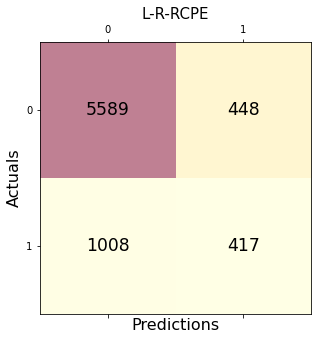

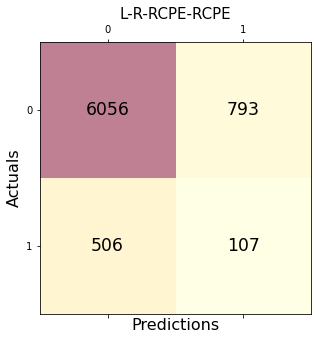

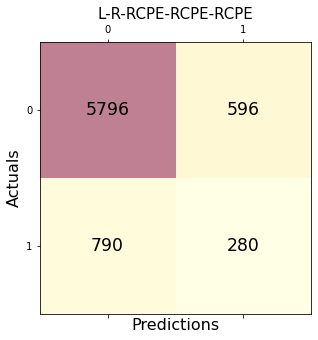

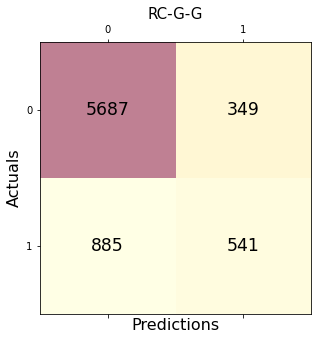

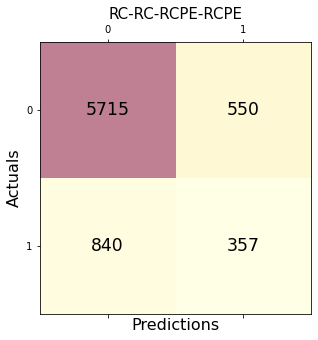

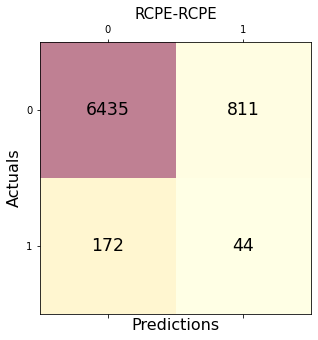

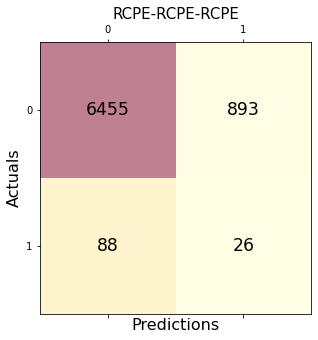

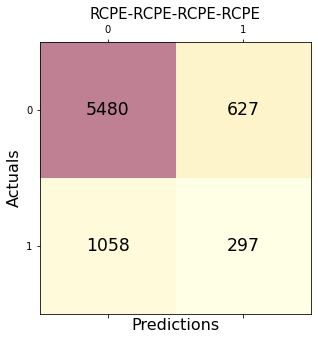

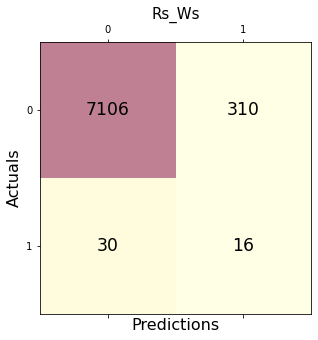

In [19]:
# Plot Confusion matrix for each class
for i,cl in enumerate(cfm):
    # Setting the attributes
    fig, px = plt.subplots(figsize=(5, 5))
    px.matshow(cl, cmap=plt.cm.YlOrRd, alpha=0.5)
    for m in range(cl.shape[0]):
        for n in range(cl.shape[1]):
            px.text(x=m,y=n,s=cl[m, n], va='center', ha='center', size='xx-large')

    # Sets the labels
    plt.xlabel('Predictions', fontsize=16)
    plt.ylabel('Actuals', fontsize=16)
    plt.title(classes_dict[i], fontsize=15)
    plt.show()